# Import libraries

Import all of the libraries that you might need to do analyses for this notebook.  A library is a toolset of scripts you can use to achieve a purpose.  Two examples of great libraries are [Pandas](https://pandas.pydata.org/) and [Matplotlib](https://matplotlib.org/).

In [1]:
import pandas as pd
import numpy as np

import requests
import seaborn as sns

import scipy.stats as sp

import statsmodels.api as sm


import datetime

import matplotlib.pyplot as plt

%matplotlib inline

import pathlib

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15
rcParams['pdf.fonttype'] = 42
inline_rc = dict(plt.rcParams)


from pyproj import CRS
from pyproj import Transformer

import geopandas

from shapely.geometry import Point

import wellapplication as wa

# Set Directories

In [2]:
main_path = pathlib.Path("G:/Shared Drives/UGS_Groundwater/Projects/Pahvant_Valley/")
figure_dir = main_path / "Writing" / "Figures" 
raw_dir = main_path / "Pahvant_Basins" / "Pahvant_Basins4"
save_place = main_path / "Pahvant_Basins" / "GEE_out" / "byhydrodiv"
gis_path = main_path / "GIS_Pahvant"
#G:\Shared drives\UGS_Groundwater\Projects\Pahvant_Valley\Pahvant_Basins\GEE_out
#save_place = "GEE_Summary_Out"


# Custom Functions

Define any custom functions to be used later in the script.

## Get the HUC12 for any location

In [3]:
def get_huc(x):
    """Receive the content of ``url``, parse it as JSON and return the object.

    :param x: [longitude, latitude]

    :returns: HUC12, HUC12_Name - 12 digit hydrologic unit code of location and the name associated with that code
    """
    values = {
        'geometry': '{:},{:}'.format(x[0], x[1]),
        'geometryType': 'esriGeometryPoint',
        'inSR': '4326',
        'spatialRel': 'esriSpatialRelIntersects',
        'returnGeometry': 'false',
        'outFields': 'huc12,name',
        'returnDistinctValues': 'true',
        'f': 'pjson'}

    huc_url = 'https://hydro.nationalmap.gov/arcgis/rest/services/wbd/MapServer/6/query?'
    # huc_url = 'https://services.nationalmap.gov/arcgis/rest/services/USGSHydroNHDLarge/MapServer/10/query?'
    # huc_url2 = 'https://services.nationalmap.gov/arcgis/rest/services/nhd/mapserver/8/query?'
    response = requests.get(huc_url, params=values)
    repurl = response.url
    repjsn = response.json()
    print(repurl)
    return repjsn['features'][0]['attributes']['huc12'], repjsn['features'][0]['attributes']['name']

## Functions for Summary Statistics of Water Levels

In [4]:

def my_agg(x):
    avgtype='avgDiffWL'
    names = {
        'mean': x[avgtype].mean(),
        'std': x[avgtype].std(),
        'min': x[avgtype].min(),
        'max': x[avgtype].max(),
        'median': x[avgtype].median(),
        'cnt': (np.count_nonzero(~np.isnan(x[avgtype]))),
        'err_pls': (np.mean(x[avgtype]) + (np.std(x[avgtype]) * 1.96)),
        'err_min': (np.mean(x[avgtype]) - (np.std(x[avgtype]) * 1.96))
        #'5 percent': np.percentile(x[avgtype], 5),
        #'95 percent': np.percentile(x[avgtype], 95)
    }

    return pd.Series(names, index=list(names.keys()))

def get_avg_wl(data, numObs=50, grptype='bytime', grper='12M'):
    """Calculates standardized statistics for a list of stations or a huc from the USGS
    avgDiffWL = average difference from mean WL for each station
    :param numObs: minimum observations per site required to include site in analysis; default is 50
    :param avgtype: averaging technique for site data; options are 'avgDiffWL','stdWL','cdm','avgDiff_dWL', and 'std_dWWL'; default is 'stWL'
    :param grptype: way to group the averaged data; options are 'bytime' or 'monthly' or user input; default 'bytime'
    :param grper: only used if 'bytime' called; defaults to '12M'; other times can be put in
    :return:
    """
    # stationWL = pd.merge(siteinfo, data, on = 'site_no')
    data.reset_index(inplace=True)
    data.set_index(['datetime'], inplace=True)
    # get averages by year, month, and site number
    site_size = data.groupby('site_no').size()
    wl_long = data[data['site_no'].isin(list(site_size[site_size >= numObs].index.values))]
    # eliminate any duplicate site numbers
    siteList = list(wl_long.site_no.unique())
    for site in siteList:
        mean = wl_long.loc[wl_long.site_no == site, 'value'].mean()
        std = wl_long.loc[wl_long.site_no == site, 'value'].std()
        meandiff = wl_long.loc[wl_long.site_no == site, 'value'].diff().mean()
        stddiff = wl_long.loc[wl_long.site_no == site, 'value'].diff().std()
        wl_long.loc[wl_long.site_no == site, 'diff'] = wl_long.loc[wl_long.site_no == site, 'value'].diff()
        wl_long.loc[wl_long.site_no == site, 'avgDiffWL'] = wl_long.loc[wl_long.site_no == site, 'value'] - mean
        wl_long.loc[wl_long.site_no == site, 'stdWL'] = wl_long.loc[wl_long.site_no == site, 'avgDiffWL'] / std
        wl_long.loc[wl_long.site_no == site, 'cdm'] = wl_long.loc[wl_long.site_no == site, 'avgDiffWL'].cumsum()
        wl_long.loc[wl_long.site_no == site, 'avgDiff_dWL'] = wl_long.loc[
                                                                  wl_long.site_no == site, 'diff'] - meandiff
        wl_long.loc[wl_long.site_no == site, 'std_dWL'] = wl_long.loc[
                                                              wl_long.site_no == site, 'avgDiff_dWL'] / stddiff

    if grptype == 'bytime':
        grp = pd.Grouper(freq=grper)
    elif grptype == 'monthly':
        grp = wl_long.index.month
    else:
        grp = grptype

    # this statement reduces bias from one station
    wllong = wl_long.groupby(['site_no',grp]).mean()
    wllong.index = wllong.index.droplevel(level=0)
    # this statement gets the statistics
    wl_stats = wllong.groupby([grp]).apply(my_agg)

    wl_stats = wl_stats

    return wl_stats

def plt_avgwl(wl_stats, maxdate = [0,0,0], mindate=[1960,1,1],):

    if maxdate[0] == 0:
        maxdate = [datetime.datetime.today().year,1,1]

    grpd = wl_stats
    x2 = grpd.index
    y3 = grpd['mean']
    y2 = grpd['median']

    fig = plt.figure()
    ax = fig.add_subplot(111)

    rcParams['figure.figsize'] = 15, 10
    rcParams['legend.numpoints'] = 1
    plt.plot(x2, y3, '+-', color='green', label='Median')
    ax.plot(x2, y2, '+-', color='red', label='Average')
    ax.fill_between(x2, grpd['err_min'], grpd['err_pls'], alpha=0.2, label='2 Standard Deviations', linewidth=0)

    ax.set_ylabel('Mean dWL (ft)', color='red')
    ax.invert_yaxis()
    ax.grid()
    ax2 = ax.twinx()
    ax2.plot(x2, grpd['cnt'], label='Number of Wells Observed')
    ax2.set_ylim(0, int(grpd['cnt'].max()) * 3)
    ax2.set_yticks(range(0, int(grpd['cnt'].max()), int(grpd['cnt'].max() / 10)))
    ax2.set_ylabel('Number of Wells Observed', color='blue')
    ax2.yaxis.set_label_coords(1.03, 0.2)
    ax.set_xlim(pd.datetime(*mindate), pd.datetime(*maxdate))
    date_range = pd.date_range('{:}-{:}-{:}'.format(*mindate), '{:}-{:}-{:}'.format(*maxdate), freq='36M')
    #date_range = date_range.map(lambda t: t.strftime('%Y-%m-%d'))
    date_range_labs = date_range.map(lambda t: t.strftime('%Y'))
    ax.set_xticks(date_range,labels=date_range_labs)
    ax.set_xlabel('date')
    # ask matplotlib for the plotted objects and their labels
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)

    return fig,ax,ax2

## Functions to Plot Linear Regression Uncertainty

In [5]:
#https://stackoverflow.com/questions/27164114/show-confidence-limits-and-prediction-limits-in-scatter-plot/63560689#63560689

def plot_ci_manual(t, s_err, n, x, x2, y2, ax=None):
    """Return an axes of confidence bands using a simple approach.
    
    Notes
    -----
    .. math:: \left| \: \hat{\mu}_{y|x0} - \mu_{y|x0} \: \right| \; \leq \; T_{n-2}^{.975} \; \hat{\sigma} \; \sqrt{\frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}}
    .. math:: \hat{\sigma} = \sqrt{\sum_{i=1}^n{\frac{(y_i-\hat{y})^2}{n-2}}}
    
    References
    ----------
    .. [1] M. Duarte.  "Curve fitting," Jupyter Notebook.
       http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/CurveFitting.ipynb
    
    """
    if ax is None:
        ax = plt.gca()
    
    ci = t * s_err * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    ax.fill_between(x2, y2 + ci, y2 - ci, color="#b9cfe7", 
                    alpha=0.6, edgecolor="None", label = 'Confidence Interval')

    return ax


def plot_ci_bootstrap(xs, ys, resid, nboot=500, ax=None):
    """Return an axes of confidence bands using a bootstrap approach.

    Notes
    -----
    The bootstrap approach iteratively resampling residuals.
    It plots `nboot` number of straight lines and outlines the shape of a band.
    The density of overlapping lines indicates improved confidence.

    Returns
    -------
    ax : axes
        - Cluster of lines
        - Upper and Lower bounds (high and low) (optional)  Note: sensitive to outliers

    References
    ----------
    .. [1] J. Stults. "Visualizing Confidence Intervals", Various Consequences.
       http://www.variousconsequences.com/2010/02/visualizing-confidence-intervals.html

    """ 
    if ax is None:
        ax = plt.gca()

    bootindex = sp.random.randint

    for _ in range(nboot):
        resamp_resid = resid[bootindex(0, len(resid) - 1, len(resid))]
        # Make coeffs of for polys
        pc = sp.polyfit(xs, ys + resamp_resid, 1)                   
        # Plot bootstrap cluster
        ax.plot(xs, sp.polyval(pc, xs), "b-", linewidth=2, alpha=3.0 / float(nboot))

    return ax


# Import data from USGS NWIS

The following command uses data services created by the USGS to download data from the [USGS NWIS site](https://waterdata.usgs.gov/nwis).  This command will download all groundwater levels (gwlevels) from two HUC regions, which are the watersheds that include the Pahvant study area.  The function called below will also accept station numbers and a lat-long box.

In [6]:
pahvant_wells = wa.nwis('gwlevels',['16030008','16030005'],'huc')

connection successful


After the function runs, it generates two objects:
* `pahvant_wells.sites` - This is a dataframe that has site information for the region 
* `pahvant_wells.data` - This is a dataframe with all of the groundwater level data for the region.

Lets preview the site data (see below).

In [7]:
pahvant_wells.sites.head()

,site_no,dec_lat_va,dec_long_va,dec_coord_datum_cd,station_nm,data_type_cd
0,384253112384901,38.714690,-112.647722,EPSG:4326,(C-24- 7)21bab- 1,GW
1,384253112384901,38.714690,-112.647722,EPSG:4326,(C-24- 7)21bab- 1,GW
2,384253112384901,38.714690,-112.647722,EPSG:4326,(C-24- 7)21bab- 1,GW
3,384428112341701,38.741079,-112.572165,EPSG:4326,(C-24- 6) 7bad- 1,GW
4,384428112341701,38.741079,-112.572165,EPSG:4326,(C-24- 6) 7bad- 1,GW


Let's also look at the top few rows of the data table.  Note that this table has two tiers of row indexers: a `site_no` index and a `datetime` index.  Each site has several readings over time.  Some sites just have one or two readings. The `value` column in this table is the depth to groundwater in feet.

Next we will clean the groundwater data by removing all levels that have flags for pumping or bad data.

In [8]:
gwl_data = pahvant_wells.cleanGWL(pahvant_wells.data)

C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v4\Lib\site-packages\wellapplication\usgs.py:212: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  data[colm] = data[colm].apply(lambda x: self.xcheck(x), 1)


The basic `pahvant_wells.sites` is a nice table, but sometimes you want more site metadata than that.  We can leverage the USGS NWIS Water Service to get a table of all sites in the region with additional metadata.

In [9]:
baseurl = "https://waterservices.usgs.gov/nwis/site/?"
kwargs = {'format':'rdb',
          'huc':'16030008,16030005',
          'siteOutput':'expanded',
          'siteStatus':'all'}

resp = requests.get(baseurl, params=kwargs)
linefile = resp.iter_lines()
numlist = []
num = 0
for line in linefile:
    if line.startswith(b"#"):
        numlist.append(num)
    num += 1
numlist.append(numlist[-1] + 2)



pahvant_well_sites = pd.read_table(resp.url, sep="\t", skiprows=numlist)
print(pahvant_well_sites.columns)

Index(['agency_cd', 'site_no', 'station_nm', 'site_tp_cd', 'lat_va', 'long_va',
       'dec_lat_va', 'dec_long_va', 'coord_meth_cd', 'coord_acy_cd',
       'coord_datum_cd', 'dec_coord_datum_cd', 'district_cd', 'state_cd',
       'county_cd', 'country_cd', 'land_net_ds', 'map_nm', 'map_scale_fc',
       'alt_va', 'alt_meth_cd', 'alt_acy_va', 'alt_datum_cd', 'huc_cd',
       'basin_cd', 'topo_cd', 'instruments_cd', 'construction_dt',
       'inventory_dt', 'drain_area_va', 'contrib_drain_area_va', 'tz_cd',
       'local_time_fg', 'reliability_cd', 'gw_file_cd', 'nat_aqfr_cd',
       'aqfr_cd', 'aqfr_type_cd', 'well_depth_va', 'hole_depth_va',
       'depth_src_cd', 'project_no'],
      dtype='object')


In [10]:
pahvant_well_sites.head()

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,local_time_fg,reliability_cd,gw_file_cd,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no
0,USGS,10219000,"SEVIER RIVER NEAR JUAB, UT",ST,392229.0,1120220.0,39.374680,-112.039656,M,F,...,Y,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USGS,10219200,"CHICKEN CREEK NEAR LEVAN, UT",ST,393308.0,1114945.0,39.552180,-111.829928,M,S,...,Y,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USGS,10219201,"CHICKEN CREEK NR. LEVAN, UTAH",ST,393308.0,1114945.0,39.552180,-111.829928,M,S,...,Y,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USGS,10219300,"DEEP CREEK NEAR LEVAN, UTAH",ST,393000.0,1115000.0,39.499959,-111.834093,M,F,...,Y,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USGS,10220000,"SEVIER RIVER NR MILLS, UTAH",ST,393400.0,1120800.0,39.566620,-112.134106,M,F,...,Y,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


When we imported these data, Python didn't recognize the date columns, and treated the `site_no` column as a long integer, so we will change those to the formats that we want:

In [11]:
#pahvant_well_sites['construction_dt'] = pahvant_well_sites['construction_dt'].apply(lambda x: pd.to_datetime(x, format='%Y%m%d',errors='coerce'),1) 
#pahvant_well_sites['inventory_dt'] = pahvant_well_sites['inventory_dt'].apply(lambda x: pd.to_datetime(x, format='%Y%m%d',errors='coerce'),1) 
pahvant_well_sites['site_no'] = pahvant_well_sites['site_no'].apply(lambda x: f"{x}")

Next, we will transform the coordinates of the site data to Albers Conic, which is a better projection for distance and area calculations.

In [12]:
crs1 = CRS.from_epsg(4269) #NAD83
crs2 = CRS.from_epsg(6350) #Albers Conic
proj = Transformer.from_crs(crs1,crs2)
pahvant_well_sites['X'] = pahvant_well_sites[['dec_long_va','dec_lat_va']].apply(lambda x: proj.transform(x[1],x[0])[0],1)
pahvant_well_sites['Y'] = pahvant_well_sites[['dec_long_va','dec_lat_va']].apply(lambda x: proj.transform(x[1],x[0])[1],1)


C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_32512\1364668095.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pahvant_well_sites['X'] = pahvant_well_sites[['dec_long_va','dec_lat_va']].apply(lambda x: proj.transform(x[1],x[0])[0],1)
C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_32512\1364668095.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pahvant_well_sites['Y'] = pahvant_well_sites[['dec_long_va','dec_lat_va']].apply(lambda x: proj.transform(x[1],x[0])[1],1)


Now we will examine the filtered groundwater level data.  We will get the range and number of data values collected for each site

In [13]:
allcounts = gwl_data.reset_index().groupby('site_no').count().sort_values(['value'],ascending=False)

def dtrng(x):
    d = {}
    dtlist = sorted(x['datetime'])
    d['first_date'] = dtlist[0]
    d['last_date'] = dtlist[-1]
    d['date_range'] = d['last_date'] - d['first_date']
    #print(d['first_date'],dtlist)
    return pd.Series(d, index=['first_date','last_date','date_range'])
    
daterante = gwl_data.reset_index().groupby('site_no').apply(dtrng)
bigvals = allcounts[allcounts['value'] >= 100]
count_dict = allcounts['value'].to_dict()
pahvant_well_sites = pahvant_well_sites.reset_index()
pahvant_well_sites = pahvant_well_sites.set_index('site_no')
pahvant_well_sites['totalmeasure'] = pahvant_well_sites.apply(lambda x: count_dict.get(str(x.name)),1)
pahvant_well_sites['first_date'] = pahvant_well_sites.apply(lambda x: daterante.loc[str(x.name),'first_date'] if str(x.name) in daterante.index else None,1)
pahvant_well_sites['last_date'] = pahvant_well_sites.apply(lambda x: daterante.loc[str(x.name),'last_date'] if str(x.name) in daterante.index else None,1)
pahvant_well_sites['date_range'] = pahvant_well_sites.apply(lambda x: daterante.loc[str(x.name),'date_range'] if str(x.name) in daterante.index else None,1)
pahvant_well_sites['date_range_days'] = pahvant_well_sites['date_range'].dt.days

geometry = [Point(xy) for xy in zip(pahvant_well_sites.X, pahvant_well_sites.Y)]
#df = df.drop(['Lon', 'Lat'], axis=1)
pahvant_sites_gdf = geopandas.GeoDataFrame(pahvant_well_sites, crs=crs2, geometry=geometry)

C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_32512\4278933379.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daterante = gwl_data.reset_index().groupby('site_no').apply(dtrng)


Let's get an idea of the groundwater trends in the area using an anomoly function built into the library we have been using.  This function averages the deviation from average of all the wells in the area, then plots it:

C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v4\Lib\site-packages\wellapplication\usgs.py:212: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  data[colm] = data[colm].apply(lambda x: self.xcheck(x), 1)
C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v4\Lib\site-packages\wellapplication\usgs.py:260: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wl_long.loc[wl_long.site_no == site, 'diff'] = wl_long.loc[wl_long.site_no == site, 'value'].diff()
C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v4\Lib\site-packages\wellapplication\usgs.py:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

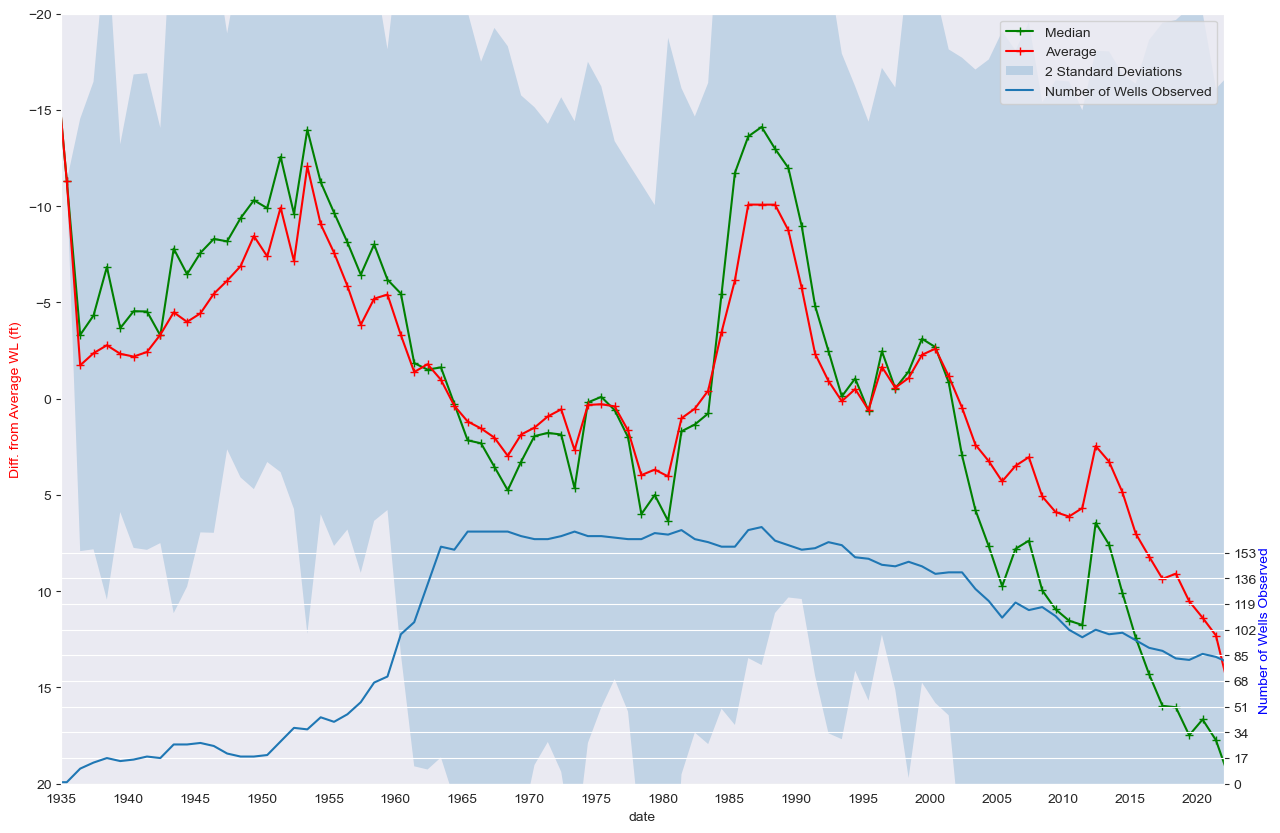

In [14]:
avg_wls = pahvant_wells.avg_wl(avgtype='avgDiffWL')

fig,ax,ax2 = pahvant_wells.pltavgwl()
ax.set_ylim(20,-20)

strt = pd.to_datetime("1935/01/01")
end = pd.to_datetime("2022/01/01")
dtrng = pd.date_range(start=strt,end=end,freq='5YS')

ticklabs = [f"{i:%Y}" for i in dtrng]

ax.set_xlim(strt,end)
ax.set_xticks(dtrng)
ax.set_xticklabels(ticklabs)

ax.set_ylabel("Diff. from Average WL (ft)")
plt.savefig(figure_dir / "avg_wl_change.pdf")
plt.savefig(figure_dir / "avg_wl_change.jpg")

# Do some GIS

We can use the geographic columns in the `pahvant_well_sites` table to turn the table into a GeoDataFrame, which is a table with a built in georeference.

In [15]:
geometry = [Point(xy) for xy in zip(pahvant_well_sites.X, pahvant_well_sites.Y)]
#df = df.drop(['Lon', 'Lat'], axis=1)
pahvant_sites_gdf = geopandas.GeoDataFrame(pahvant_well_sites, crs=crs2, geometry=geometry)

gdb = "G:/Shared drives/UGS_Groundwater/Projects/Pahvant_Valley/GIS_Pahvant/Pahvant/Pahvant.gdb"
watersheds = geopandas.read_file(gdb, driver='FileGDB', layer='watersheds')
hucs = [1603000513,1603000514,1603000515,1603000517,1603000801,1603000802,1603000803,1603000804,1603000805]

hydrodivs = geopandas.read_file(gis_path / 'Valley_Hydrogeologic_Divisions.shp')
hydrodivs_wgs = hydrodivs.to_crs('epsg:4269')

watersheds = watersheds.to_crs(pahvant_sites_gdf.crs)
watersheds['dummy'] = 1
poly_sheds = watersheds.dissolve(by='dummy').loc[1, 'geometry']
pahvant_sites_gdf = pahvant_sites_gdf[pahvant_sites_gdf.within(poly_sheds)]

fig,ax =plt.subplots(1,1)
watersheds.plot(ax=ax)
pahvant_sites_gdf.plot(ax=ax,color='red')

ValueError: Null layer: 'watersheds'

We can get a subset of the sites that were sampled in March 2022 using the following query:

In [ ]:
pahvant_sites_march2022 = pahvant_sites_gdf[(pahvant_sites_gdf['last_date']>pd.to_datetime('2022-02-01'))&(pahvant_sites_gdf['last_date']<pd.to_datetime('2022-04-20'))]

In [ ]:
pahvant_sites_march2022.plot()

Grab the groundwater levels from the data table and append them onto the sites we selected.

In [ ]:
marchdata = gwl_data[(gwl_data.index.get_level_values(1).month==3)&(gwl_data.index.get_level_values(1).year==2022)]

pahvant_sites_march2022 = pahvant_sites_march2022.sort_index()

wldict = marchdata.reset_index().set_index('site_no')['value'].to_dict()

pahvant_sites_march2022['march2022_wl'] = pahvant_sites_march2022.index.map(wldict)

Export the geographic data as a geojson file.

In [16]:
#out_march = "G:/Shared drives/UGS_Groundwater/Projects/Pahvant_Valley/GIS_Pahvant/Pahvant/usgs_wells_march_2022.geojson"
#pahvant_sites_march2022.drop(columns=['date_range'],axis=1).to_file(out_march, driver="GeoJSON")

Export the geographic data as a geopackage file.

In [17]:
out_march = "G:/Shared drives/UGS_Groundwater/Projects/Pahvant_Valley/GIS_Pahvant/Pahvant/usgs_wells_march_2022.gpkg"
pahvant_sites_march2022.drop(columns=['date_range'],axis=1).to_file(out_march,layer='usgs_wells', driver="GPKG")

NameError: name 'pahvant_sites_march2022' is not defined

Export all of the geographic data to a shapefile format

In [18]:
alldata = gwl_data.groupby(gwl_data.index.get_level_values(0)).median().to_dict()['value']
allsites = pahvant_well_sites
allsites['depth_to_water'] = allsites.index.map(alldata)

allsites = allsites.dropna(subset=['dec_lat_va','dec_long_va'])

dtp_df = allsites.dtypes.to_frame()
for dtp in dtp_df.index:
    if dtp_df.loc[dtp].values[0] == '<M8[ns]' or dtp_df.loc[dtp].values[0] == 'timedelta64[ns]':
        print(dtp)
        allsites[dtp] = allsites[dtp].apply(lambda x: str(x),1)

geometry = [Point(xy) for xy in zip(allsites['dec_long_va'], allsites['dec_lat_va'])]
#df = df.drop(['Lon', 'Lat'], axis=1)
crs2 = 4269
allsites_gdf = geopandas.GeoDataFrame(allsites, crs=crs2, geometry=geometry)

crs3 = 26912
allsites_gdf = allsites_gdf.to_crs(crs3)

out_march = "G:/Shared drives/UGS_Groundwater/Projects/Pahvant_Valley/GIS_Pahvant/Pahvant/usgs_all_wells_v3.shp"
allsites_gdf.to_file(out_march, driver='ESRI Shapefile')

TypeError: agg function failed [how->median,dtype->object]

In [ ]:
gwl_data.reset_index().set_index('datetime')

In [ ]:
dtp_df = pahvant_sites_march2022.dtypes.to_frame()

for dtp in dtp_df.index:
    if dtp_df.loc[dtp].values[0] == '<M8[ns]' or dtp_df.loc[dtp].values[0] == 'timedelta64[ns]':
        print(dtp)
        pahvant_sites_march2022[dtp] = pahvant_sites_march2022[dtp].apply(lambda x: str(x),1)

out_march = "G:/Shared drives/UGS_Groundwater/Projects/Pahvant Valley/GIS_Pahvant/Pahvant/usgs_wells_march_2022v2.shp"
pahvant_sites_march2022[['station_nm','march2022_wl','last_date','geometry']].to_file(out_march, driver='ESRI Shapefile')

In [ ]:
pahvant_sites_march2022[['station_nm','march2022_wl','last_date','geometry']]

Select the last big water level measurement campaign from the 1980s and export the geographic data to a shapefile:

In [ ]:
thirosdata = gwl_data[(gwl_data.index.get_level_values(1).year==1986)&(gwl_data.index.get_level_values(1).month.isin([3]))]
thirossites = pahvant_well_sites[pahvant_well_sites.index.isin(thirosdata.index.get_level_values(0).unique())]

thirosdata = thirosdata.reset_index().set_index('site_no')
thirosdata = thirosdata.groupby(thirosdata.index).first()
thirossites = thirossites.reset_index().drop_duplicates(subset='site_no').set_index('site_no')
thirossitedata = pd.concat([thirossites,thirosdata],axis=1)
thirossitedata = thirossitedata.dropna(subset=['dec_lat_va','dec_long_va'])

dtp_df = thirossitedata.dtypes.to_frame()
for dtp in dtp_df.index:
    if dtp_df.loc[dtp].values[0] == '<M8[ns]' or dtp_df.loc[dtp].values[0] == 'timedelta64[ns]':
        print(dtp)
        thirossitedata[dtp] = thirossitedata[dtp].apply(lambda x: str(x),1)

geometry = [Point(xy) for xy in zip(thirossitedata['dec_long_va'], thirossitedata['dec_lat_va'])]
#df = df.drop(['Lon', 'Lat'], axis=1)
crs2 = 4269
thirossitedata_gdf = geopandas.GeoDataFrame(thirossitedata, crs=crs2, geometry=geometry)

crs3 = 26912
thirossitedata_gdf = thirossitedata_gdf.to_crs(crs3)

out_march = "G:/Shared drives/UGS_Groundwater/Projects/Pahvant Valley/GIS_Pahvant/Pahvant/usgs_wells_march_1986.shp"
thirossitedata_gdf.to_file(out_march, driver='ESRI Shapefile')

In [ ]:
thirosdata = gwl_data[gwl_data.index.get_level_values(1).year==1986]

pahvant_sites_march2021 = pahvant_sites_march2021.sort_index()

wldict = marchdata.reset_index().set_index('site_no')['value'].to_dict()

pahvant_sites_march2021['march2021_wl'] = pahvant_sites_march2021.index.map(wldict)

# Import Pumping Data and Compare to WL Change Data

## Import pumping data

In [21]:
pumpdata = main_path / "Groundwater_Pumping" / "Groundwater_Conditions_In_Utah.xlsx"
pumping = pd.read_excel(pumpdata,index_col='Year')


## Filter well data by area

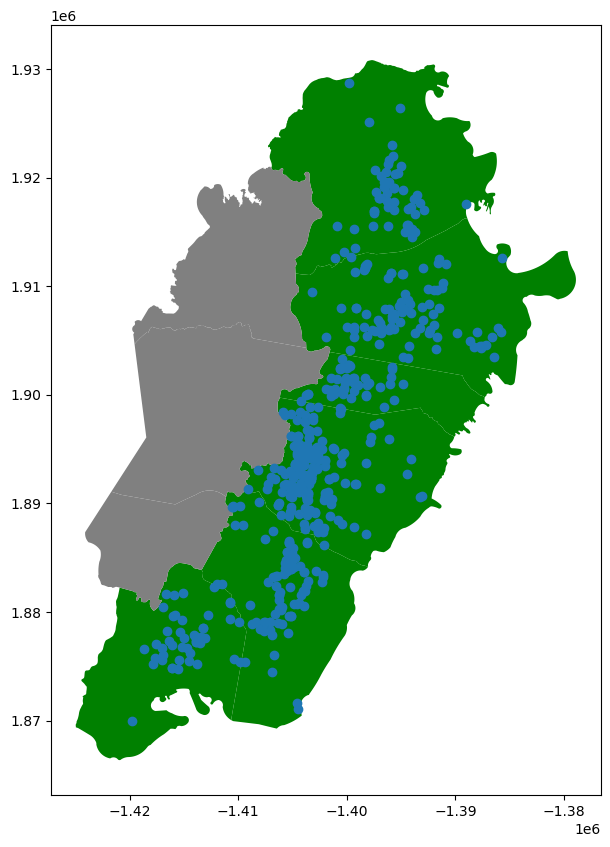

In [22]:
valley = hydrodivs[(hydrodivs['Bdrk_v_Val']=='Valley')&(~hydrodivs['WRarea'].isin(['West Desert','Oasis','Clear Lake']))]
basalt = hydrodivs[(hydrodivs['Bdrk_v_Val']=='Basalt')&(~hydrodivs['WRarea'].isin(['West Desert','Oasis','Clear Lake']))]

valley = valley.to_crs(pahvant_sites_gdf.crs)
valley['dummy'] = 1
valley_sheds = valley.dissolve(by='dummy').loc[1, 'geometry']
pahvant_valley_sites = pahvant_sites_gdf[pahvant_sites_gdf.within(valley_sheds)]

fig, ax = plt.subplots(1,1)

valley.plot(color='green',ax=ax)
basalt.plot(color='grey',ax=ax)
pahvant_valley_sites.plot(ax=ax)

pv_gwl_data = gwl_data[gwl_data.index.get_level_values(0).isin(pahvant_valley_sites.index)]

## Calculate WL change statistics for Valley Area

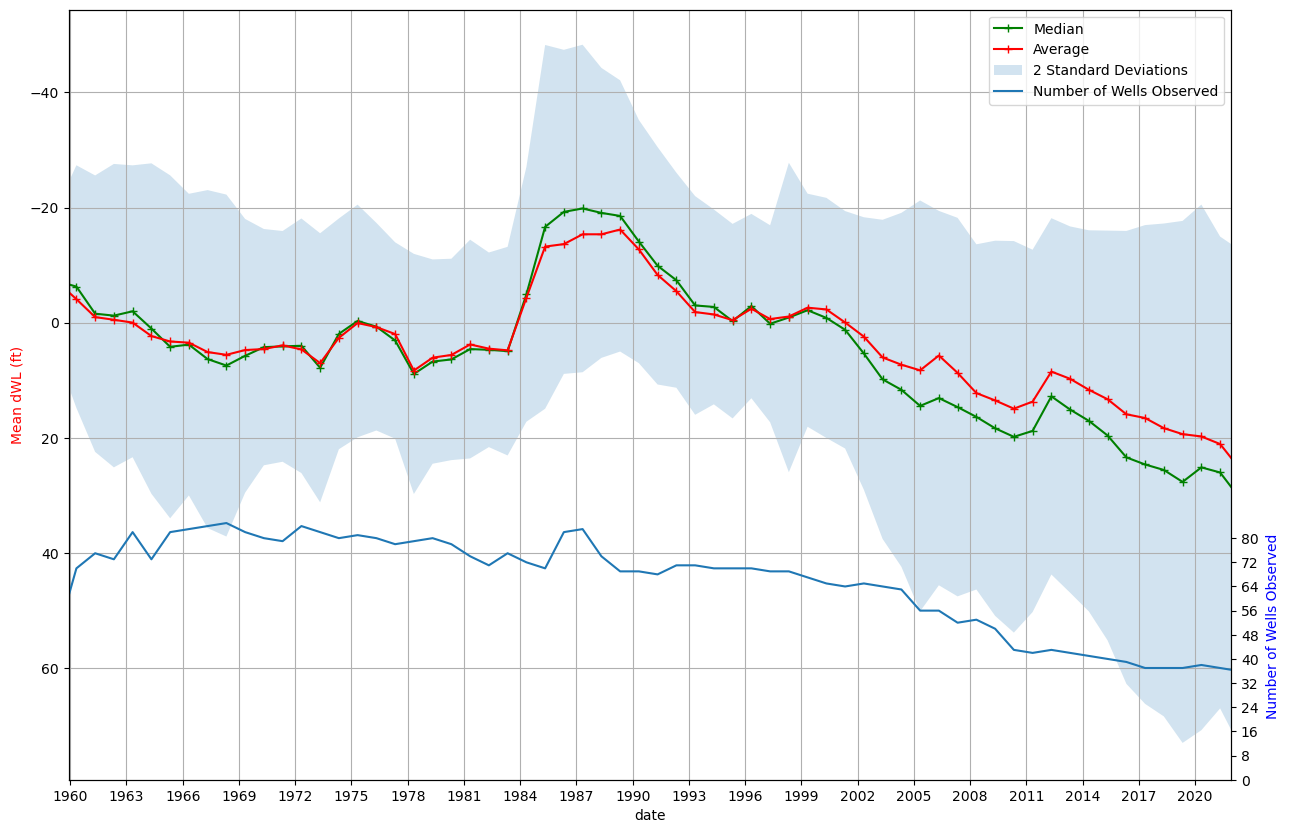

In [23]:
np.warnings.filterwarnings('ignore')
pv_avg_wl = get_avg_wl(pv_gwl_data)
fig,ax,ax2 = plt_avgwl(pv_avg_wl,maxdate=[2022, 1, 1])
avg_yr_wls = pv_avg_wl.reset_index().set_index(pv_avg_wl.index.year)
avg_yr_wls = avg_yr_wls[avg_yr_wls.index < 2023]
plt.savefig(figure_dir / "avg_wl_change_valleyfill.pdf")

## Calculate Relationship Between Pumping and Water Levels

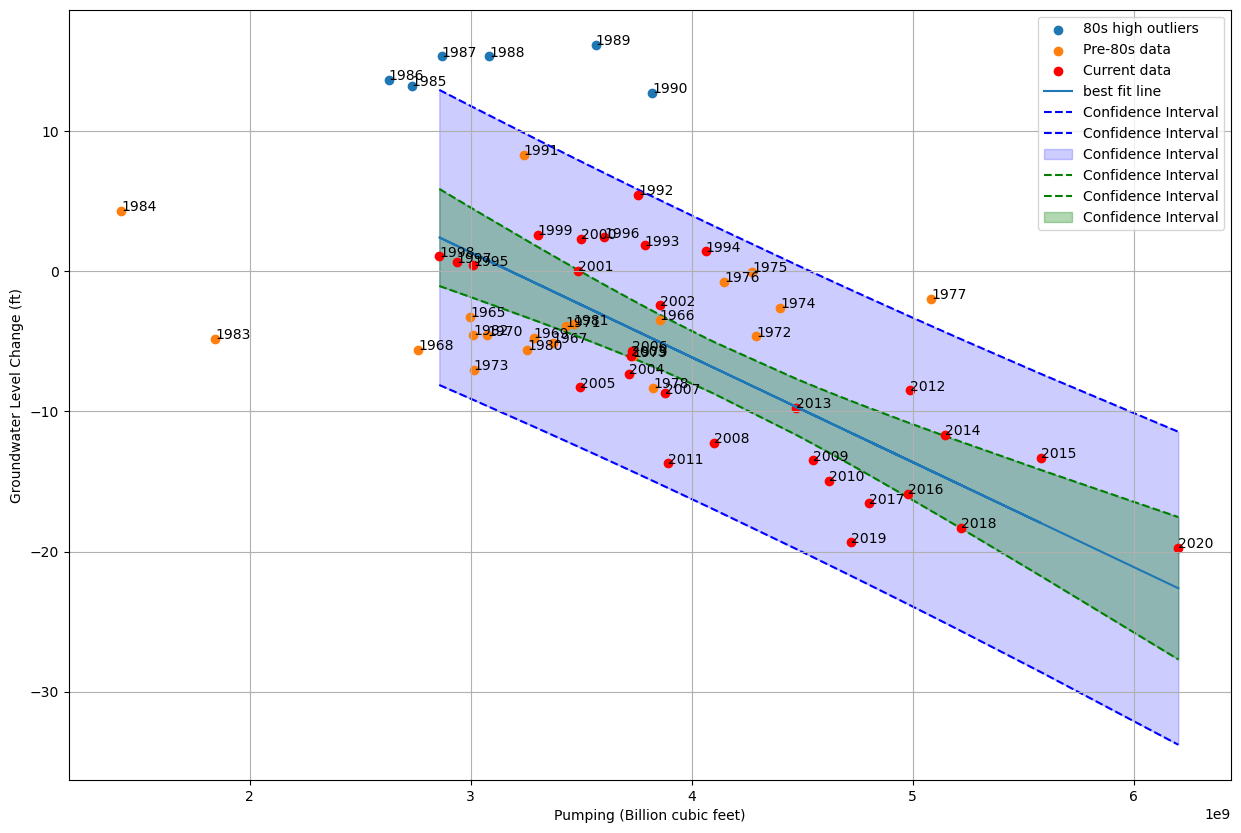

In [25]:
pumpwl = pd.concat([pumping['Total'],avg_yr_wls[['mean','median']]], axis=1).rename(columns={'mean':'wls_mean',
                                                                                            'median':'wls_median'})
pumpwl = pumpwl.dropna()
pumpwl['wls_median'] = pumpwl['wls_median']*-1
pumpwl['Total_ft3'] = pumpwl['Total']*43559.9
pumpwl = pumpwl[pumpwl.Total > 0]
pumpwls = pumpwl[(pumpwl.index < 1985)|(pumpwl.index > 1990)]
outliers = pumpwl[(pumpwl.index >= 1985)&(pumpwl.index <= 1990)]
new_wls = pumpwls[pumpwls.index >= 1992]
old_wls = pumpwls[pumpwls.index < 1992]

fig, ax = plt.subplots(1,1)

#ax.scatter(pumpwls['Total_ft3'], pumpwls['wls_median'])

ax.scatter(outliers['Total_ft3'], outliers['wls_median'],label='80s high outliers')
ax.scatter(old_wls['Total_ft3'], old_wls['wls_median'],label='Pre-80s data')
ax.scatter(new_wls['Total_ft3'], new_wls['wls_median'],label='Current data',color='red')

for ind in pumpwl.index:
    if ind in pumpwls.index:
        ax.text(x = pumpwls.loc[ind,'Total_ft3'], y= pumpwls.loc[ind,'wls_median'], 
                 s= pumpwls.loc[ind].name)
    elif ind in outliers.index:
        ax.text(x = outliers.loc[ind,'Total_ft3'], y= outliers.loc[ind,'wls_median'], 
                 s= outliers.loc[ind].name)

        
df = new_wls
#define predictor and response variables
y = df['wls_median']
x = df['Total_ft3']

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
mainmodel = sm.OLS(y, x).fit()
predictions = mainmodel.get_prediction()
df_stats = predictions.summary_frame(alpha=0.05)
dfstats = pd.concat([df,df_stats],axis=1)
dfstats = dfstats.sort_values('Total_ft3')
ax.plot(df['Total_ft3'],df['Total_ft3']*mainmodel.params[1] + mainmodel.params[0], label='best fit line')

ax.plot(dfstats['Total_ft3'],dfstats['obs_ci_lower'],
                color='blue',linestyle="--", zorder=0,label='Confidence Interval')

ax.plot(dfstats['Total_ft3'],dfstats['obs_ci_upper'],
                color='blue',linestyle="--", zorder=0,label='Confidence Interval')

ax.fill_between(dfstats['Total_ft3'],dfstats['obs_ci_lower'],dfstats['obs_ci_upper'],
                color='blue', alpha=0.2,zorder=0,label='Confidence Interval')

ax.plot(dfstats['Total_ft3'],dfstats['mean_ci_lower'],
                color='green',linestyle="--", zorder=0,label='Confidence Interval')

ax.plot(dfstats['Total_ft3'],dfstats['mean_ci_upper'],
                color='green',linestyle="--", zorder=0,label='Confidence Interval')


ax.fill_between(dfstats['Total_ft3'],dfstats['mean_ci_lower'],dfstats['mean_ci_upper'],
                color='green',alpha=0.3,zorder=0,label='Confidence Interval')
ax.set_xlabel('Pumping (Billion cubic feet)')
ax.set_ylabel('Groundwater Level Change (ft)')
plt.legend()
plt.grid()
plt.savefig(figure_dir / "pump_v_dwl.pdf")
#mainmodel.
#mainmodel.summary()

In [26]:
mainmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             wls_median   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     44.92
Date:                Tue, 07 Feb 2023   Prob (F-statistic):           3.40e-07
Time:                        16:36:11   Log-Likelihood:                -85.896
No. Observations:                  29   AIC:                             175.8
Df Residuals:                      27   BIC:                             178.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.8201      4.709      5.058      0.000      14.158      33.483
Total_ft3  -7.488e-09   1.12e-09     -6.702      0.000   -9.78e-09    -5.2e-09
==============================================================================
Omnibus:                        1.425   Durbin-Watson:                   1.105
Prob(Omnibus):                  0.490   Jarque-Bera (JB):                1.060
Skew:                           0.199   Prob(JB):                        0.589
Kurtosis:                       2.152   Cond. No.                     2.20e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.2e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Iterate WL & Pumping Model to determine Bulk Storage

$$\Delta WL = {I_{ua} \over S_{aq}} - {Q \over Area \times S_{aq}} \approx b- aQ_s$$


$$Q_{stable} = {b \over a} = I_{ua} \times Area $$

$$ I_{ua} = {Q_{stable} \over Area} $$

$$ S_{aq} = {I_{ua} \over b} $$

In [83]:
valley_area

11917197418.027134

In [27]:
slope = []
interc = []
qstable = []
iua = []
saq = []

valley_area = np.sum(valley.geometry.area)*10.7639

for i in range(0,5000):
    rsmp = new_wls.sample(n=15)
    #define predictor and response variables
    y = rsmp['wls_median']
    x = rsmp['Total_ft3']

    #add constant to predictor variables
    x = sm.add_constant(x)

    #fit linear regression model
    submod = sm.OLS(y, x).fit()
    slpi = submod.params[1]
    slope.append(slpi)
    interci = submod.params[0]
    interc.append(interci)
    qi = interci/slpi
    qstable.append(qi)
    ii = qi/valley_area
    iua.append(ii)
    saq.append(ii/interci)
    
    
modelstats = pd.DataFrame({'slope':slope,'intercept':interc,'Qstable':qstable,'Iua':iua,'Saq':saq})

confidence = mainmodel.conf_int()


In [28]:
print(modelstats['Qstable'].median()*2.29569e-5)
print(modelstats['Qstable'].quantile(0.025)*2.29569e-5)
print(modelstats['Qstable'].quantile(0.975)*2.29569e-5)
print(modelstats['Qstable'].mean()*2.29569e-5)

-73219.61331819689
-79689.49950656093
-64689.35702607268
-72988.3174550588


In [29]:
print(modelstats['Saq'].median())
print(modelstats['Saq'].quantile(0.025))
print(modelstats['Saq'].quantile(0.975))
print(modelstats['Saq'].mean())

-0.011217326639305927
-0.013781738350343537
-0.008257148715839581
-0.011164993907026629


In [30]:
avg_wl_change = 40

total_water_lost_from_storage = avg_wl_change*modelstats['Saq'].median()*valley_area*2.29569e-5#/(2022-1986)
ann_water_lost_from_storage = total_water_lost_from_storage/(2022-1986)
print(total_water_lost_from_storage)
print(ann_water_lost_from_storage)

-122754.3056164425
-3409.8418226789586


In [31]:
2022-1986

36

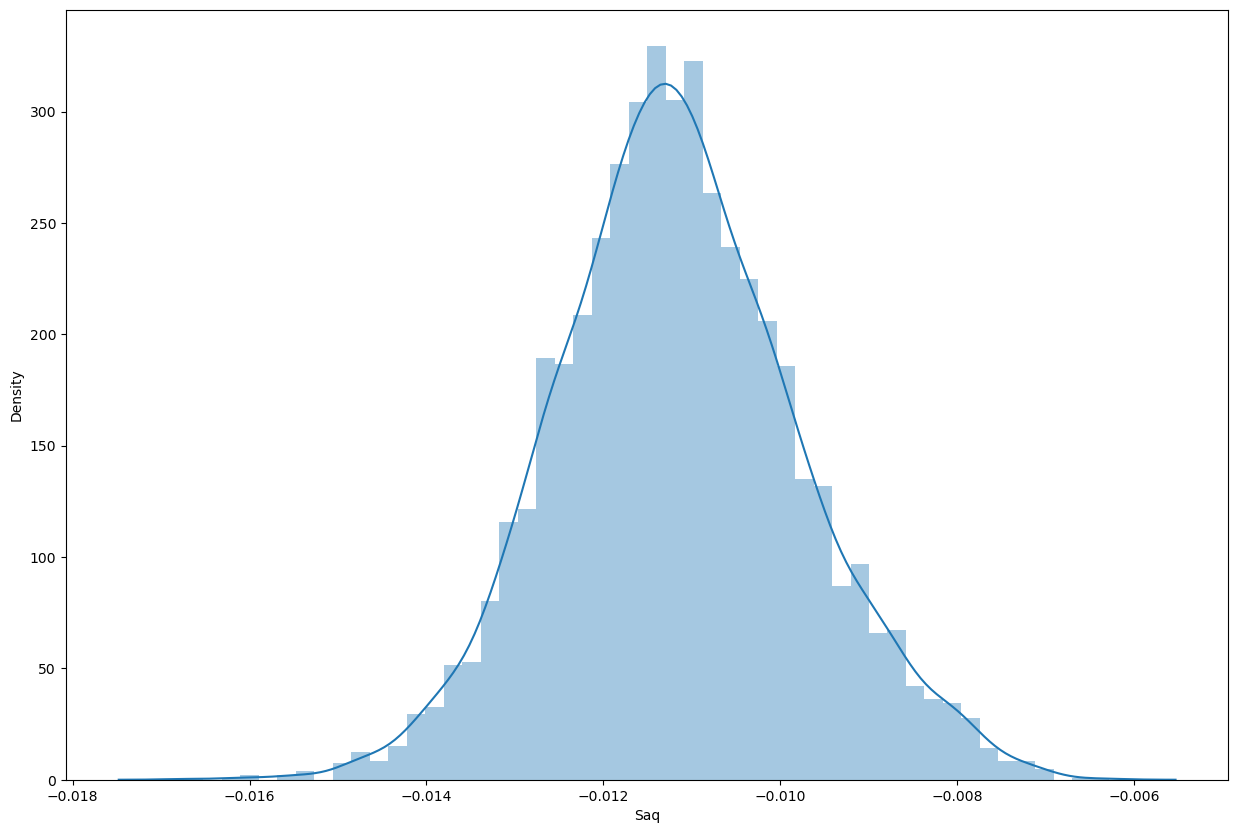

In [32]:
s = modelstats['Saq']

ax = sns.distplot(s)
plt.savefig(figure_dir / "saq_dist.pdf")

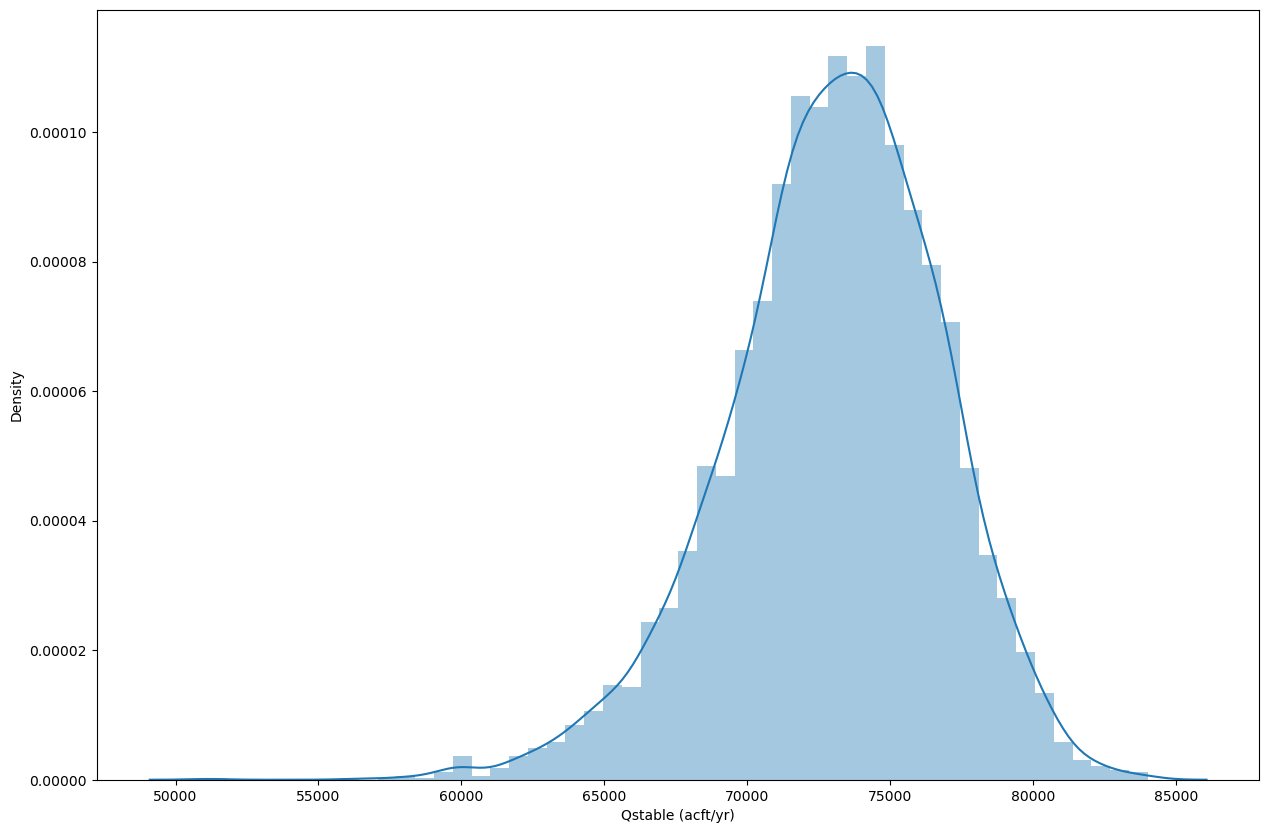

In [33]:
s = -2.29569e-5*modelstats['Qstable']
ax = sns.distplot(s)
plt.xlabel('Qstable (acft/yr)')
plt.savefig(figure_dir / "Qstable_dist.pdf")

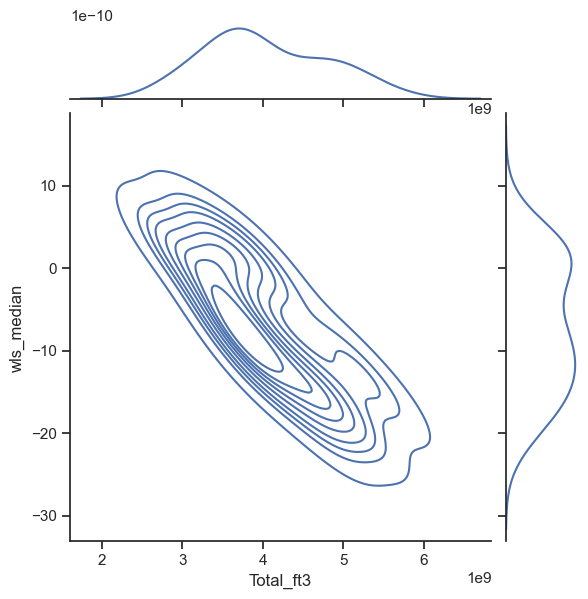

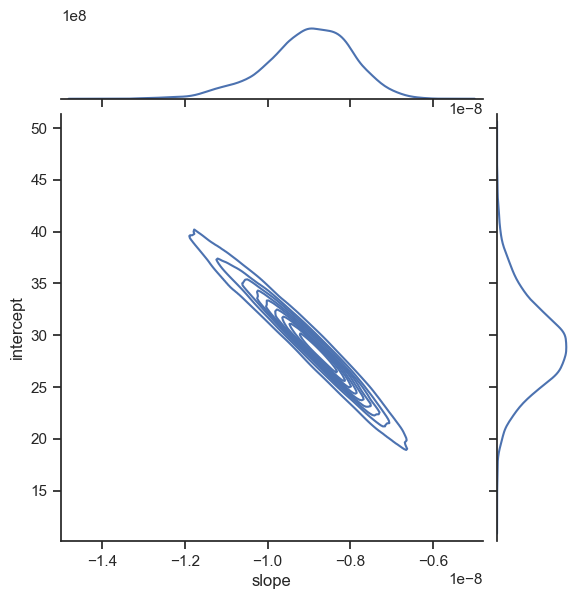

In [79]:
import seaborn as sns
sns.set_theme(style="ticks")

# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=new_wls,
    x="Total_ft3", y="wls_median",
    kind="kde")

g = sns.jointplot(
    data=modelstats,
    x="slope", y="intercept",
    kind="kde")



In [228]:
distr = multivariate_normal(cov = cov, mean = data_means, allow_singular=True)
distr.pdf(x)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [87]:
Q = round(mainmodel.params[0]/abs(mainmodel.params[1])*2.29569e-5,0)
print(Q)
valley_area = np.sum(valley.geometry.area)*10.7639
basalt_area = np.sum(basalt.geometry.area)*10.7639

I = (mainmodel.params[0]/abs(mainmodel.params[1]))/valley_area#(valley_area+basalt_area)
I2 = (mainmodel.params[0]/abs(mainmodel.params[1]))/(valley_area+basalt_area)

S = I/mainmodel.params[0]
S2 = I2/mainmodel.params[0]
print(S)
print(S2)

74179.0
0.009422521157627796
0.006676026080839551
